# Preparation

data classes, general functions

In [1]:
from __future__ import annotations

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from enum import Enum, auto
from dataclasses import dataclass
from typing import List

In [2]:
KNN_TRAIN = "./mnist_small/train.csv"
KNN_TEST = "./mnist_small/test.csv"

names = ["label"] + [f"Pix {i}" for i in range(28*28)]

train_df = pd.read_csv(KNN_TRAIN, names=names)
test_df = pd.read_csv(KNN_TEST, names=names)

## Look at the data format and repartition

In [3]:
train_df

,label,Pix 0,Pix 1,Pix 2,Pix 3,Pix 4,Pix 5,Pix 6,Pix 7,Pix 8,...,Pix 774,Pix 775,Pix 776,Pix 777,Pix 778,Pix 779,Pix 780,Pix 781,Pix 782,Pix 783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test_df

,label,Pix 0,Pix 1,Pix 2,Pix 3,Pix 4,Pix 5,Pix 6,Pix 7,Pix 8,...,Pix 774,Pix 775,Pix 776,Pix 777,Pix 778,Pix 779,Pix 780,Pix 781,Pix 782,Pix 783
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Coding part
The following sections contain the coding part of the project

* Image visualization (helper tool)

In [5]:
def visualize_image(mnist_array: np.array):
    """Visualize the given flattened image from the mnist dataset with its expected label"""
    label = mnist_array[0]
    image = mnist_array[1:].reshape(28, 28)

    plt.figure()
    plt.title(f"Handwritten [{label}]") 
    plt.imshow(image, cmap='gray', vmin=0, vmax=255)

    plt.show()

* Distances and trivial score computation

In [6]:
class DistanceType(Enum):
    EUCLIDIAN = auto()
    MANHATTAN = auto()

@dataclass
class Score():
    """Hold the score for a training set evalutation. Contain the score evalutation method"""
    total: int
    success: int
    failures: int

    accuracy: float

    @classmethod
    def compute_score(total: int, successes: int, failures: int) -> Score:
        """Compute the score from the given successes / failures
        
        Returns
        -----
            A score object containing the information
        """
        accuracy = successes / total

        return Score(total, successes, failures, accuracy)

* Custom classifier, heavily coupled to test dataset but optimized for efficient tests on k via memoization of the distance map

In [7]:
class KnnClassifier:
    """Class encapsulating the logic of the KNN algorithm"""
    #Work with arrays to be more efficient
    labels: np.array
    data: np.array
    test_set: np.array

    memoization_distancemap: dict[DistanceType, List[np.array]]

    def __init__(self, train_df: pd.DataFrame, test_df: pd.DataFrame) -> None:
        """Init the KNN classifier with the training and testing dataset"""
        self.train(train_df)
        self.test_set = test_df.to_numpy()
        self.memoization_distancemap = {dt.value: {} for dt in DistanceType}

    ### Distance management ###
    def distance_function(self, distance: DistanceType) -> callable:
        match distance:
            case DistanceType.MANHATTAN:
                return self.manhattan_distance_matrix
            case DistanceType.EUCLIDIAN:
                return self.euclidian_distance_matrix
            case _:
                return NotImplementedError(f"Distance function {distance} not known/supported")

    def euclidian_distance_matrix(self, image: np.array):
        """Compute the distance as the difference in intensity level pixel-wise between the input image and the classifier training data"""
        #use numpy functions as they are made to be efficient with vecotrized input
        return np.sqrt(np.sum(np.power(np.subtract(image, self.data), 2), axis=1))

    def manhattan_distance_matrix(self, image: np.array):
        """Compute the distance as the difference in intensity level pixel-wise between the input image and the classifier training data"""
        #use numpy functions as they are made to be efficient with vecotrized input
        return np.sum(np.abs(np.subtract(image, self.data)), axis=1)

    def train(self, train_df: pd.DataFrame):
        """Train this KNN classifier with the given dataset"""
        #Assume MNIST: Label as first byte, image as the rest
        self.labels = train_df.loc[:, 'label']
        self.data = train_df.drop(['label'], axis=1, inplace=False).to_numpy()
        print(f"KNN prepared with {len(self.data)} data")

    def optimize_dataset(self) -> None:
        """Optimize the internal classifier dataset in two rounds - eliminating redundancy inforation and removing outliers.
        Further classifications are done using the new dataset."""
        print(f"Performing condensation from dataset of {len(self.data)} elements...")
        self.condense()
        print(f"Dataset now has {len(self.data)} elements")

    def condense(self) -> None:
        """Reduce redundancy at little cost. In-place on the training dataset of the classifier"""
        working_set = [(i,data) for i,data in enumerate(self.data)] #working set of (index, array)
        working_set = working_set[1:] #Remove first element, as first element init the new result set
        initial_labels = self.labels #Keep expected labels
        #Init new dataset with first item
        self.labels = self.labels[:1]
        result_set = self.data[:1]
        self.data = result_set

        #Assume default distance
        distance = DistanceType.MANHATTAN
        
        print(f"Starting condensation")
        change = True
        while change:
            change = False

            #Do a 1-NN on ourself with the dataset result, if wrong, move x from working dataset to result
            indexes_to_delete = []
            print(F"New iteration of the working set")
            i = 1
            for (original_index, array) in working_set:
                print(f"\rWorking set item {i:4}/{len(working_set)}", end = "")
                i+=1
                expected_label = initial_labels[original_index]
                classified_label = self.classify_single(array, None, distance, k=1, avoid_memoization=True)
                if classified_label != expected_label:
                    #If the 1-k classification is not correct, switch the image from working set to data set as it is significant
                    indexes_to_delete.append(original_index) #Keep index to delete, don't delete on list while looping on it
                    self.data: np.ndarray
                    self.data = np.append(self.data, [array], axis=0)
                    self.labels = np.append(self.labels, expected_label)
                    change = True
            print()

            if change:
                print(f"Changes during iteration detected - {len(indexes_to_delete)} items switched to result set")
                working_set = [(original_index, array) for (original_index, array) in working_set if original_index not in indexes_to_delete]
        print(f"No change detected, condensation is over")
                
    def classify_single_verbose(self, image_array: np.array, k: int, distance: DistanceType = DistanceType.EUCLIDIAN) -> None:
        """Classify an image by performing the KNN on the training dataset. 
        Don't return anything, focus on displaying steps to verify function execution"""
        #Assume the MNIST format, extract expected label
        distance_fct = self.distance_function(distance)
        expected_label = image_array[0]
        print(f"Trying to correctly classify image with expected label [{expected_label}]")
        image = image_array[:1]

        print(f"Computing distances...")
        #Compute distance over each DF line
        distances = distance_fct(image)
        print(f"Extract of distances: {distances[:15]}")

        #extract best class amongst distances
        #Sort distances
        sorted_indexes = np.argsort(distances)
        dist_classes = [(distances[ind], self.labels[ind]) for ind in sorted_indexes[:20]]
        print(f"Found best distance-classes: {dist_classes}")

        #Extract sorted label of the k-neighbourhood from distances
        neighbourhood = [self.labels[ind] for ind in sorted_indexes[:k]]
        #count label frequency
        sorted_freq_labels = Counter(neighbourhood).most_common() #List of tuple (label, count) sorted by the count
        print(f"Most common occurences: {sorted_freq_labels}")

        #In case of tie: fallback to K=1
        if len(sorted_freq_labels) > 1 and sorted_freq_labels[0][1] == sorted_freq_labels[1][1]:
            classified_label = self.labels[sorted_indexes[0]]
            print(f"Tie between {sorted_freq_labels[0][0]} and {sorted_freq_labels[1][0]}, selecting closest {classified_label}")
        #else simply take most common
        else:
            classified_label = sorted_freq_labels[0][0]
            print(f"Selecting {classified_label}")

    def classify_single(self, image_array: np.array, test_index: int, distance_type: DistanceType, k: int, avoid_memoization: bool = False) -> int:
        """Classify an image by performing the KNN on the training dataset. 

        Arguments
        ----
            image_array: The image to classify from the test set
            i: test_index
         
        Returns
        -----
            The classified label
        """
        #Compute distance over each DF line
        #Add memoization: Keep distances if possible, assume always same test input
        if avoid_memoization:
            distance_fct = self.distance_function(distance_type)
            distances = distance_fct(image_array)
        else:
            try:
                distances = self.memoization_distancemap[distance_type.value][test_index]
            except KeyError:
                distance_fct = self.distance_function(distance_type)
                distances = distance_fct(image_array)
                self.memoization_distancemap[distance_type.value][test_index] = distances

        #extract best class amongst distances
        #Sort distances
        sorted_indexes = np.argsort(distances)
        #Extract sorted label of the k-neighbourhood from distances
        neighbourhood = [self.labels[ind] for ind in sorted_indexes[:k]]
        #count label frequency
        sorted_freq_labels = Counter(neighbourhood).most_common() #List of tuple (label, count) sorted by the count

        #In case of tie: fallback to K=1
        if len(sorted_freq_labels) > 1 and sorted_freq_labels[0][1] == sorted_freq_labels[1][1]:
            classified_label = self.labels[sorted_indexes[0]]
        #else simply take most common
        else:
            classified_label = sorted_freq_labels[0][0]
        
        return classified_label
    
    def precompute_distances(self, distance_type: DistanceType) -> None:
        """Precompute the distances in order to have very fast KNN classification later on
        
        Args
        -----
            test_dataset: A pd dataframe containing images formated as the mnist dataset, with the label as the first byte
        """
        distance_fct = self.distance_function(distance_type)
        for i, test_array in enumerate(self.test_set):
            image_to_test = test_array[1:]
            distances = distance_fct(image_to_test)
            self.memoization_distancemap[distance_type.value][i] = distances

    def classify_dataset(self, distance: DistanceType, k: int) -> Score:
        """Classify each item on the test dataset and yields an evaluation score
        
        Args
        -----
            test_dataset: A pd dataframe containing images formated as the mnist dataset, with the label as the first byte

        Returns
        ----
            A score object
        """
        successes = 0
        total = len(self.test_set)
        
        for i, test_array in enumerate(self.test_set):
            expected_label = test_array[0]
            image_to_test = test_array[1:]
            classified_label = self.classify_single(image_to_test, i, distance, k)
            if expected_label == classified_label:
                successes += 1
        
        failures = total - successes
        accuracy = successes / total

        return Score(successes+failures, successes, failures, accuracy)

# Manual Test
First, let's try our solution and see with a few numbers if the mecanism is in place with one image classification

In [8]:
knnClassifier = KnnClassifier(train_df, test_df)

KNN prepared with 1000 data


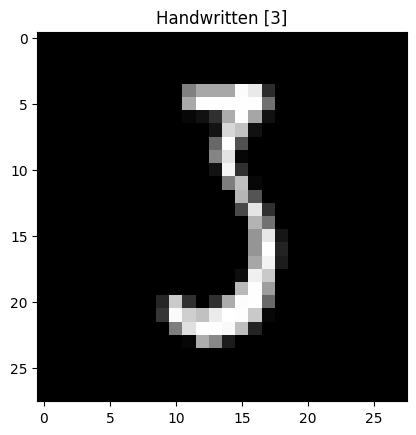

In [9]:
test_image = test_df.sample().to_numpy()[0]
visualize_image(test_image)

In [10]:
knnClassifier.classify_single_verbose(test_image, 5)

Trying to correctly classify image with expected label [3]
Computing distances...
Extract of distances: [1708.0737689  3351.91109667 1771.70482869 1350.70240986 2394.66135393
 3093.35723769 1824.1450052  2242.46315466 1755.01709393 2738.13476659
 2309.42503667 1086.67934553 2393.20245696 2255.14811044 1873.20046978]
Found best distance-classes: [(1086.6793455293057, 1), (1185.898393624007, 1), (1350.7024098594036, 1), (1363.2193513884697, 4), (1366.8050336459842, 1), (1417.111498788998, 1), (1425.0242103206529, 1), (1426.5149841484315, 1), (1432.9448698397298, 1), (1443.8981958573117, 1), (1452.2547985804695, 1), (1465.4200762921191, 1), (1479.1903190597213, 6), (1491.1113305182816, 1), (1495.2982979994326, 1), (1502.5188850726636, 1), (1505.0465109092145, 1), (1508.3882126296267, 4), (1523.362727652216, 1), (1525.9066157534019, 1)]
Most common occurences: [(1, 4), (4, 1)]
Selecting 1


# Now do the whole test dataset once
Test the model accuracy with different values of k, with or without condensation (reduction of the dataset)

In [11]:
print(f"Classifying dataset with K=5")
score = knnClassifier.classify_dataset(DistanceType.EUCLIDIAN, k=5)
print(f"Correct predictions: {score.success}/{score.total}, accuracy of {score.accuracy:.2}%")

Classifying dataset with K=5
Correct predictions: 885/1000, accuracy of 0.89%


# Accuracy of your classification for K = {1, 3, 5, 10, 15} using the best distance metric.

In [12]:
def evaluate_on_k(distance: DistanceType, optimize: bool) -> None:
    knnClass = KnnClassifier(train_df, test_df)
    
    if optimize:
        knnClass.optimize_dataset()

    print(f"Precomputing distances...")
    knnClass.precompute_distances(distance)
    print(f"Distance map complete")

    for k in [1, 3, 5, 10, 15]:
        print(f"Evaluating for k={k}...")
        score: Score = knnClass.classify_dataset(distance, k)
        print(f"For k={k}, score is {score.accuracy}% ({score.success}/{score.total})")

# Test all K on raw dataset

In [13]:
for distance in DistanceType:
    print(f"Evaluating distance {distance.name}")
    evaluate_on_k(distance, False)
    print()

Evaluating distance EUCLIDIAN
KNN prepared with 1000 data
Precomputing distances...
Distance map complete
Evaluating for k=1...
For k=1, score is 0.886% (886/1000)
Evaluating for k=3...
For k=3, score is 0.89% (890/1000)
Evaluating for k=5...
For k=5, score is 0.885% (885/1000)
Evaluating for k=10...
For k=10, score is 0.875% (875/1000)
Evaluating for k=15...
For k=15, score is 0.847% (847/1000)

Evaluating distance MANHATTAN
KNN prepared with 1000 data
Precomputing distances...
Distance map complete
Evaluating for k=1...
For k=1, score is 0.875% (875/1000)
Evaluating for k=3...
For k=3, score is 0.865% (865/1000)
Evaluating for k=5...
For k=5, score is 0.869% (869/1000)
Evaluating for k=10...
For k=10, score is 0.845% (845/1000)
Evaluating for k=15...
For k=15, score is 0.814% (814/1000)



# test all K on condensated dataset

In [14]:
for distance in DistanceType:
    print(f"Evaluating distance {distance.name}")
    evaluate_on_k(distance, True)
    print()

Evaluating distance EUCLIDIAN
KNN prepared with 1000 data
Performing condensation from dataset of 1000 elements...
Starting condensation
New iteration of the working set
Working set item  999/999
Changes during iteration detected - 260 items switched to result set
New iteration of the working set
Working set item  739/739
Changes during iteration detected - 60 items switched to result set
New iteration of the working set
Working set item  679/679
Changes during iteration detected - 3 items switched to result set
New iteration of the working set
Working set item  676/676
No change detected, condensation is over
Dataset now has 324 elements
Precomputing distances...
Distance map complete
Evaluating for k=1...
For k=1, score is 0.834% (834/1000)
Evaluating for k=3...
For k=3, score is 0.854% (854/1000)
Evaluating for k=5...
For k=5, score is 0.849% (849/1000)
Evaluating for k=10...
For k=10, score is 0.844% (844/1000)
Evaluating for k=15...
For k=15, score is 0.816% (816/1000)

Evaluating